In [1]:
from MySQL_connection import df

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

    ID             Cartridge    Type  Weight     BC    V0  V100  V200    E0  \
0    1   44 REMINGTON MAGNUM   Rifle     225  0.145  1870  1416  1106  1747   
1    2            357 MAGNUM   Rifle     140  0.169  1850  1458  1165  1064   
2    3            30 CARBINE   Rifle     110  0.178  2000  1601  1279   977   
3    4          35 REMINGTON   Rifle     200  0.192  2080  1697  1375  1921   
4    5      45-70 GOVERNMENT   Rifle     325  0.230  2050  1730  1451  3032   
5    6        450 BUSHMASTER   Rifle     250  0.210  2200  1835  1515  2686   
6    7            450 MARLIN   Rifle     325  0.230  2225  1887  1587  3572   
7    8      30-30 WINCHESTER   Rifle     150  0.193  2390  1974  1608  1902   
8    9         8X57MM MAUSER   Rifle     170  0.205  2360  1970  1624  2102   
9   10            444 MARLIN   Rifle     265  0.225  2325  1971  1654  3180   
10  11              458 LOTT   Rifle     500  0.295  2300  2029  1778  5872   
11  12     7.62X39MM RUSSIAN   Rifle     123  0.295 

### Let's create two dataFrames 
##### First for learning and secound for testing

In [2]:
#Creation of new df (we will use it for testing later)
#Drop the columns 'ID' 'BD100' and 'BD200' - they are useless here
test_df = df.drop(['ID', 'BD100', 'BD200'], axis=1)

#Now I create new df for learning. It contains 30 random notations from database of balistics
learning_df = pd.DataFrame(data={
                                 'Cartridge':pd.Series([], index=[],dtype=object),
                                 'Type':pd.Series([], index=[],dtype=object),
                                 'Weight':pd.Series([], index=[],dtype=object),
                                 'BC':pd.Series([], index=[],dtype=object),
                                 'V0':pd.Series([], index=[],dtype=object),
                                 'V100':pd.Series([], index=[],dtype=object),
                                 'V200':pd.Series([], index=[],dtype=object),
                                 'E0':pd.Series([], index=[],dtype=object),
                                 'E100':pd.Series([], index=[],dtype=object),
                                 'E200':pd.Series([], index=[],dtype=object),
                                })


#filling 'learning_df' with 30 random notes
for i in range(0, 30):
    
    #random index to choose a note
    j = random.randrange(0, 54-i)
    
    #extracting j'th note from test_df and inserting it into learning_df
    note = test_df.iloc[j]
    learning_df = learning_df.append(note, ignore_index=True)
    test_df = test_df.drop(test_df.index[j], axis=0)

#indexation of test_df was damaged. Let's reset it!
test_df = test_df.reset_index().drop(['index'], axis=1)


#### Let's see velocity distribution on different ditances:
(here we use only learning_df data)
### 0 feets:

mean velocty =  2604.7
std =  362.79177555974593


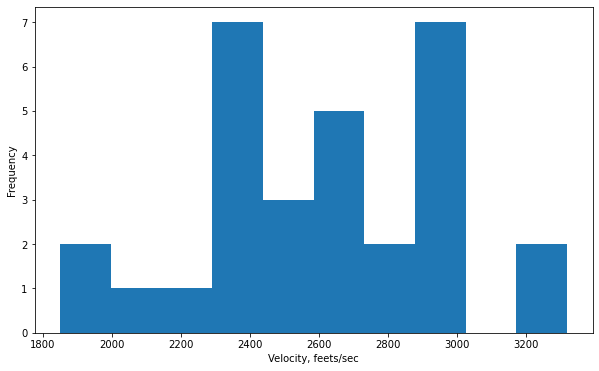

In [3]:
#Overview of 'V0' distribition 
plt.figure(figsize=(10,6))
plt.xlabel('Velocity, feets/sec')
learning_df['V0'].plot(kind='hist')

#'V0' mean and std
mean_V0 = learning_df['V0'].mean()
std_V0 = learning_df['V0'].std()

print('mean velocty = ', mean_V0)
print('std = ', std_V0)

### 100 feets :

mean velocty =  2322.4333333333334
std =  423.43917719267455


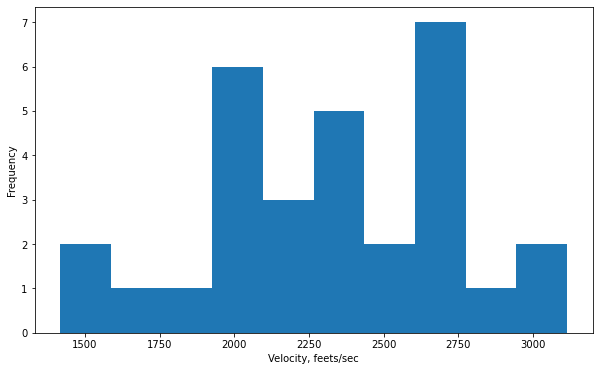

In [4]:
#Overview of 'V100' distribition 
plt.figure(figsize=(10,6))
plt.xlabel('Velocity, feets/sec')
learning_df['V100'].plot(kind='hist')

#'V100' mean and std
mean_V100 = learning_df['V100'].mean()
std_V100 = learning_df['V100'].std()

print('mean velocty = ', mean_V100)
print('std = ', std_V100)

### 200 feets :

mean velocty =  2067.6
std =  464.6951985831217


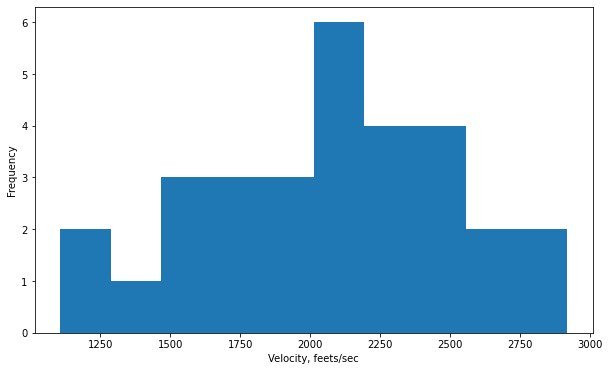

In [5]:
#Overview of 'V200' distribition 
plt.figure(figsize=(10,6))
plt.xlabel('Velocity, feets/sec')
learning_df['V200'].plot(kind='hist')

#'V200' mean and std
mean_V200 = learning_df['V200'].mean()
std_V200 = learning_df['V200'].std()

print('mean velocty = ', mean_V200)
print('std = ', std_V200)

##### Let's see also mean velocity changes due to ditance and 
##### what is the weight of bullets distribution

(0.0, 3500.0)

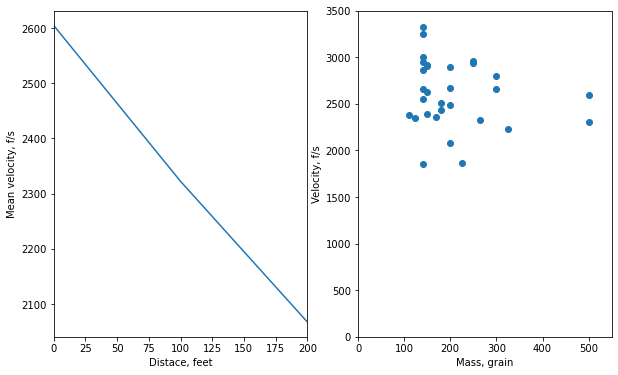

In [6]:
#I create figure for plots
figure = plt.figure(figsize=(10,6))

#creating plots and locating them
ax1 = figure.add_subplot(1, 2, 1) 
ax2 = figure.add_subplot(1,2,2)

#data for plots
mean_velocity = [mean_V0, mean_V100, mean_V200]
distance = [0, 100, 200]

mass = learning_df['Weight']
V0 = learning_df['V0']

#drawing the plots
ax1.plot(distance, mean_velocity)
ax2.scatter(mass, V0)

#set labels
ax1.set_xlabel('Distace, feet')
ax1.set_ylabel('Mean velocity, f/s')

ax2.set_xlabel('Mass, grain')
ax2.set_ylabel('Velocity, f/s')

#set axises
ax1.set_xlim(0, 200)

ax2.set_xlim(0,550)
ax2.set_ylim(0, 3500)

Left axe shows that on this distance we can suppose that velocity changes linearly. Right axe show that there are no correlation between mass and velocity. So we can make hipothesis about if we know mass, balistic coeficient and muzzle velocity we can predict how bullet's velocity changes.

# Learning

I'm gonna use linear regression model and learn it with 'learning_df'

So now I'm going to find out how much bullet velocity reduces by every feet of distance. I will find out this value for each cartridge in 'learning_df' 

In [7]:
#use linear regression as a model
model = LinearRegression()

#create a serie of reduction coeficients
reduction_coef = pd.Series(dtype=object)

#fill the serie with values for each cartridge in 'learning_df'
for i in range(0, 30):
    temporary_df = pd.DataFrame(data={'distance':[0, 100, 200], 'velocity':[learning_df.iloc[i]['V0'], learning_df.iloc[i]['V100'], learning_df.iloc[i]['V200']]})
    X = np.array([0, 100, 200])
    X = X.reshape(-1, 1)
    y = temporary_df['velocity']
   
    model.fit(X, y)
    reduction_coef.loc[len(reduction_coef)] = model.coef_[0]
    #print(model.coef_.item())
#add the serie to 'learning_df'
learning_df['red_coef'] = reduction_coef.values
learning_df.head()

,Cartridge,Type,Weight,BC,V0,V100,V200,E0,E100,E200,red_coef
0,444 MARLIN,Rifle,265,0.225,2325,1971,1654,3180,2286,1609,-3.355
1,375 WEATHERBY MAGNUM,Rifle,300,0.398,2800,2573,2357,5224,4410,3701,-2.215
2,340 WEATHERBY MAGNUM,Rifle,250,0.473,2941,2743,2554,4801,4177,3621,-1.935
3,30-30 WINCHESTER,Rifle,150,0.193,2390,1974,1608,1902,1298,861,-3.910
4,7X57MM MAUSER,Rifle,140,0.390,2660,2435,2222,2199,1844,1535,-2.190


Let's look how reduction coeficients interact with other data

Text(0.5, 0, 'Muzzle velocity, feet/sec')

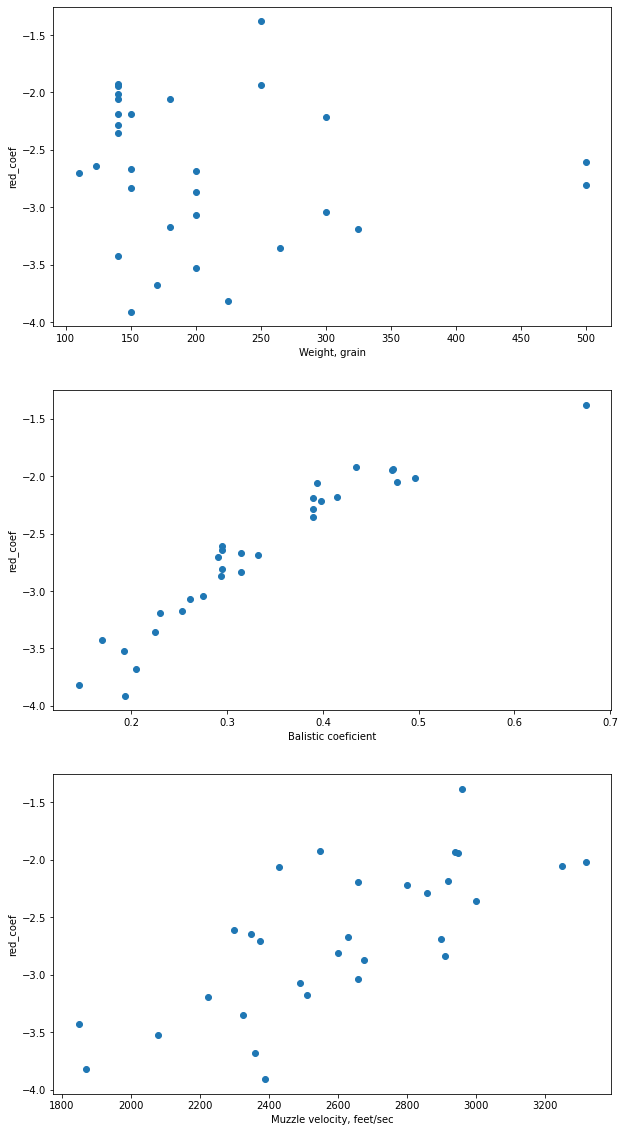

In [8]:
figure = plt.figure(figsize=(10, 20))

#Axe 1: red_coef vs Weight
ax1 = figure.add_subplot(3, 1, 1) 
ax1.scatter(learning_df['Weight'], learning_df['red_coef'])
ax1.set_ylabel('red_coef')
ax1.set_xlabel('Weight, grain')


#Axe 2: red_coef vs BC
ax2 = figure.add_subplot(3, 1, 2) 
ax2.scatter(learning_df['BC'], learning_df['red_coef'])
ax2.set_ylabel('red_coef')
ax2.set_xlabel('Balistic coeficient')


#Axe 3: red_coef vs V0
ax3 = figure.add_subplot(3, 1, 3) 
ax3.scatter(learning_df['V0'], learning_df['red_coef'])
ax3.set_ylabel('red_coef')
ax3.set_xlabel('Muzzle velocity, feet/sec')

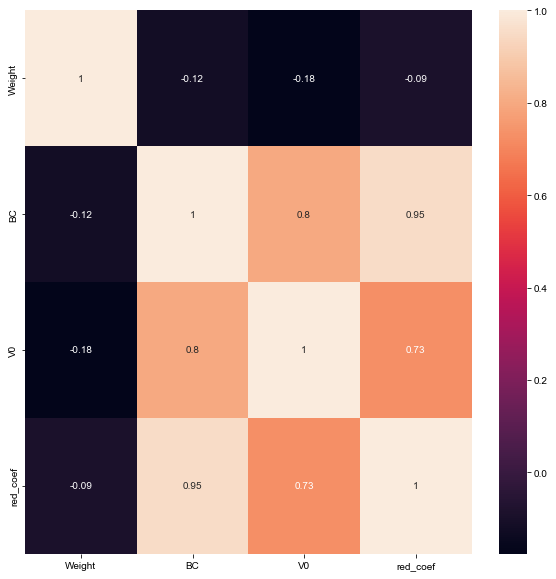

In [9]:
#correlation table
temporary_df = learning_df.filter(['Weight', 'BC', 'V0', 'red_coef'], axis=1)
temporary_df = temporary_df.astype(float)
plt.figure(figsize=(10, 10))
sns.heatmap(temporary_df.corr(), annot=True, annot_kws={'size':10})
sns.set_style('white')



    As we see from axes and correlation table: BC and red_coef have strong correlation, prety high it is between V0 and red_coef. 
    Also due to correlation table there is interaction between V0 and BC. But from phisics we know that V0 depends on amount of pouder in cartridge, so I suppose this interaction is accident.

### Multivariable Regression

In [10]:
#model training
model = LinearRegression()
X = temporary_df.drop(columns=['red_coef'])
y = temporary_df['red_coef']
model.fit(X, y)

#what we've get:
print('R^2: ', model.score(X, y))


R^2:  0.9102089991854116


R^2=0.88 - this is pretty good.
Let's check p-value and VIF for our features...


##### P-value

In [11]:
X_incl_const = sm.add_constant(X)

model = sm.OLS(y, X_incl_const)
results = model.fit()

pd.DataFrame({'coef': results.params, 'p-value': round(results.pvalues, 3)})


C:\Users\ostap\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,coef,p-value
const,-4.167115,0.000
Weight,0.000113,0.774
BC,5.580751,0.000
V0,-0.000153,0.389


##### VIF

In [12]:
vif = np.empty(4)
for i in  range (0, 4):
    vif[i] = variance_inflation_factor(exog=X_incl_const.values, exog_idx=i)
    
pd.DataFrame({'coef_name': X_incl_const.columns, 'VIF': np.around(vif, 2)})

,coef_name,VIF
0,const,92.06
1,Weight,1.03
2,BC,2.77
3,V0,2.82


Let's try also a model without 'Weight' feature, becouse if its p-vaue

In [13]:
#model training
model = LinearRegression()
X = temporary_df.drop(columns=['Weight','red_coef'])
y = temporary_df['red_coef']
model.fit(X, y)

#what we've get:
print('R^2: ', model.score(X, y))

R^2:  0.9099186197933206


This model didn't give us better R^2, but it is simpler so lets use it.